In [5]:
import pennylane as qml
import pennylane.numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from pennylane.operation import Operation, AnyWires

### Data preprocessing

In [13]:
iris = datasets.load_iris()

In [243]:
n_features=iris.data.shape[1]
#XXX: exclude class 2
xy_labels=[(iris.data[idx,:],iris.target[idx]) for idx in range(len(iris.data)) if iris.target[idx]!=2]
feature_list=[[x_lab[ft_i] for x_lab,y_lab in xy_labels] for ft_i in range(n_features)]

#standardize features
mean_std_list=[[np.mean(feature_list[ft_i]),np.std(feature_list[ft_i])] for ft_i in range(n_features)]
xy_labels_stdd=[([(el[0][ft_i]-mean_std_list[ft_i][0])/mean_std_list[ft_i][1] for ft_i in range(n_features)],el[1]) for ei,el in enumerate(xy_labels)]
#norms_list=[np.sqrt(np.sum([val**2 for val in el[0]])) for el in xy_labels_stdd]
#xy_labels_stdd=[([val/norms_list[ei] for val in el[0]],el[1]) for ei,el in enumerate(xy_labels_stdd)]
xy_labels=xy_labels_stdd
#xy_labels

X=np.array([x for x,y in xy_labels_stdd])
y_=np.array([y for x,y in xy_labels_stdd])
#y = torch.unsqueeze(torch.tensor(y,requires_grad=False), 1)
#y_hot = torch.scatter(torch.zeros((200, 2),requires_grad=False), 1, y_, 1)
X = torch.tensor(X, requires_grad=False).float()
y = torch.tensor(y_, requires_grad=False).long()

In [344]:
import pennylane.numpy as np

#def init_method(w):
#    print(w)
#    torch.nn.init.uniform_(w, a=0.0, b=0.02*np.pi)
#    print(w)
s=0.02
init_method=lambda x: torch.nn.init.uniform_(x,a=0.,b=s*np.pi)

n_qubits1=3
n_layers1 = 3
n_pars1 = 2*n_qubits1*n_layers1
dev1 = qml.device("default.mixed", wires=n_qubits1)
@qml.qnode(dev1)
def probs_single1(inputs, weights):
    shape=[2,3,3]
    nq=np.max([shape[0],shape[2]])
#    # load input
#    print("inputs:",inputs)
#    print("weights:",weights)
    #TODO: make general loadings
    for idx in range(0,n_features):
        gate=qml.RX if idx<shape[0] else qml.RZ
        gate(np.arctan(inputs[...,idx]),idx%2,id=f"$\\alpha1_{{{{{idx}}}}}$")
        
    # parameterized circuit 
    for lay_idx in range(shape[1]):
        ctr=0
        for eo in range(2):
            for qi in range(eo,nq-eo,2):
                if qi<nq-1:
                    qml.CZ(wires=[qi,qi+1])
        for gate in [qml.RX,qml.RZ]:
            for qi in range(nq):
                gate(weights[lay_idx][ctr],wires=qi,id=f"$\\theta1_{{{{{ctr}}}}}$")
                ctr+=1
        
    probs=qml.probs(wires=range(0,shape[2]))
    return probs
weight_shapes1 = {"weights": (n_layers1, n_pars1)}
qlayer1 = qml.qnn.TorchLayer(probs_single1, weight_shapes1,init_method=init_method)


n_qubits2=3
n_layers2 = 2
n_pars2 = 2*n_qubits2*n_layers2
dev2 = qml.device("default.mixed", wires=n_qubits2)
@qml.qnode(dev2)
def probs_single2(inputs, weights):
    shape=[3,2,1]
    nq=np.max([shape[0],shape[2]])
#    # load input
#    print("inputs:",inputs)
#    print("weights:",weights)
    #TODO: make general loadings
    for idx in range(0,6):
        gate=qml.RY if idx<3 else qml.RZ
        gate(torch.arctan(np.pi*(inputs[...,idx]-0.5)),idx%3,id=f"$\\alpha2_{{{{{idx}}}}}$")
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])
    for idx in range(6,8):
        #gate=[qml.RX,qml.RZ][idx-6]
        qml.RY(torch.arctan(np.pi*(inputs[...,idx]-0.5)),idx-6,id=f"$\\alpha2_{{{{{idx}}}}}$")
        
    # parameterized circuit 
    for lay_idx in range(shape[1]):
        ctr=0
        for eo in range(2):
            for qi in range(eo,nq-eo,2):
                if qi<nq-1:
                    qml.CZ(wires=[qi,qi+1])
        for gate in [qml.RY,qml.RZ]:
            for qi in range(nq):
                gate(weights[lay_idx][ctr],wires=qi,id=f"$\\theta2_{{{{{ctr}}}}}$")
                ctr+=1
        
    probs=qml.probs(wires=range(0,shape[2]))
    return probs
weight_shapes2 = {"weights": (n_layers2, n_pars2)}
qlayer2 = qml.qnn.TorchLayer(probs_single2, weight_shapes2,init_method=init_method)

/home/joe/.local/lib/python3.10/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


(<Figure size 1224x288 with 1 Axes>, <Axes:>)

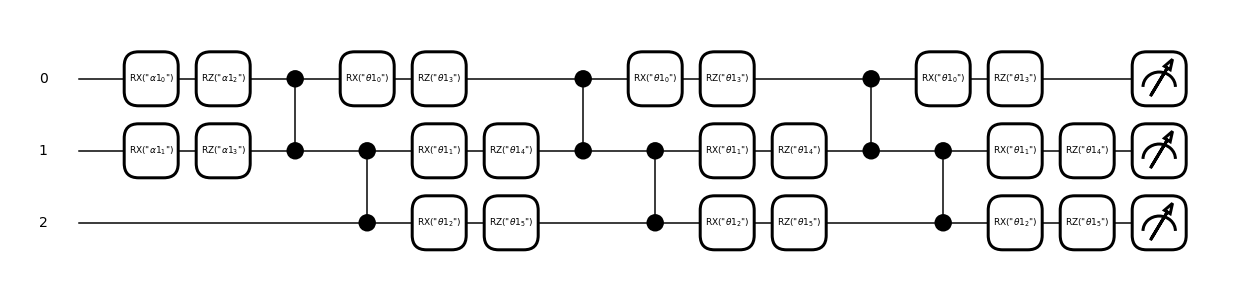

In [345]:
qml.draw_mpl(probs_single1)(torch.rand(4),np.random.random(weight_shapes1['weights']))

/home/joe/.local/lib/python3.10/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


(<Figure size 1152x288 with 1 Axes>, <Axes:>)

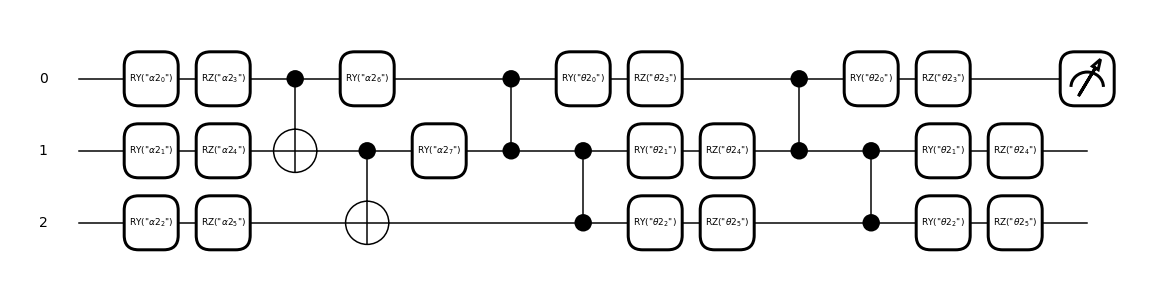

In [346]:
qml.draw_mpl(probs_single2)(torch.rand(8),np.random.random(weight_shapes2['weights']))

In [347]:
import pennylane.numpy as np
layers = [qlayer1,qlayer2]
model = torch.nn.Sequential(*layers)
#model.apply(init_method)

#opt = torch.optim.SGD(model.parameters(), lr=0.1)
opt = torch.optim.Adam(model.parameters(),lr=0.1)
#opt = torch.optim.Adam(model.parameters(),lr=0.05)
#loss = torch.nn.MSELoss()
loss = torch.nn.CrossEntropyLoss()
for pr in model.parameters():
    print(pr)

Parameter containing:
tensor([[0.0057, 0.0179, 0.0593, 0.0621, 0.0418, 0.0298, 0.0417, 0.0598, 0.0469,
         0.0137, 0.0036, 0.0268, 0.0261, 0.0168, 0.0393, 0.0624, 0.0585, 0.0088],
        [0.0002, 0.0310, 0.0175, 0.0317, 0.0439, 0.0468, 0.0175, 0.0357, 0.0095,
         0.0416, 0.0498, 0.0318, 0.0580, 0.0204, 0.0081, 0.0306, 0.0487, 0.0334],
        [0.0153, 0.0539, 0.0187, 0.0405, 0.0601, 0.0566, 0.0233, 0.0002, 0.0100,
         0.0239, 0.0081, 0.0610, 0.0332, 0.0065, 0.0100, 0.0098, 0.0120, 0.0499]],
       requires_grad=True)
Parameter containing:
tensor([[0.0429, 0.0426, 0.0490, 0.0503, 0.0495, 0.0375, 0.0155, 0.0400, 0.0327,
         0.0549, 0.0576, 0.0618],
        [0.0412, 0.0451, 0.0432, 0.0058, 0.0047, 0.0483, 0.0496, 0.0517, 0.0504,
         0.0499, 0.0415, 0.0048]], requires_grad=True)


In [348]:
#torch.nn.CrossEntropyLoss?

In [349]:
#y = y_hot.float()
#y_hot = y_hot.float()

batch_size = 8
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y)), batch_size=batch_size, shuffle=True, drop_last=True
)
epochs = 20

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

#        print(xs)
        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()
#        print(xs, model(xs),ys,loss_evaluated)

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.2988
Average loss over epoch 2: 0.2677
Average loss over epoch 3: 0.2651
Average loss over epoch 4: 0.2585
Average loss over epoch 5: 0.2562
Average loss over epoch 6: 0.2552
Average loss over epoch 7: 0.2555
Average loss over epoch 8: 0.2539
Average loss over epoch 9: 0.2497
Average loss over epoch 10: 0.2433
Average loss over epoch 11: 0.2415
Average loss over epoch 12: 0.2144
Average loss over epoch 13: 0.2114
Average loss over epoch 14: 0.2114
Average loss over epoch 15: 0.2105
Average loss over epoch 16: 0.2119
Average loss over epoch 17: 0.2103
Average loss over epoch 18: 0.2094
Average loss over epoch 19: 0.2123
Average loss over epoch 20: 0.2148
Accuracy: 99.0%


In [268]:
#predictions = torch.argmax(y_pred, axis=1).detach().numpy()

In [350]:
pbs_arr=[]
for x_lab, y_lab in zip(X,y):
    pbs=model(x_lab).detach().numpy()
    pbs_arr.append(pbs[:2])
    idx_max=np.argmax(pbs[:2])
#    y_lab_pred="0" if idx_max==1 else "1"
    print(int(y_lab), " ", idx_max, " ", pbs)
pbs_arr=np.array(pbs_arr)

0   0   [0.80643725 0.19356307]
0   0   [0.54897165 0.45102853]
0   0   [0.7560035  0.24399664]
0   0   [0.7157322  0.28426787]
0   0   [0.8337667  0.16623342]
0   0   [0.787862   0.21213822]
0   0   [0.83916146 0.16083862]
0   0   [0.8082528  0.19174755]
0   0   [0.54709375 0.45290643]
0   0   [0.66194004 0.3380602 ]
0   0   [0.7352039  0.26479617]
0   0   [0.8344243  0.16557595]
0   0   [0.5834218 0.4165784]
0   0   [0.61411995 0.38588032]
0   0   [0.5370872  0.46291304]
0   0   [0.6600357 0.3399644]
0   0   [0.78467983 0.21532026]
0   0   [0.8151713  0.18482889]
0   0   [0.5661639  0.43383634]
0   0   [0.8406384  0.15936191]
0   0   [0.63892746 0.3610729 ]
0   0   [0.8433052 0.156695 ]
0   0   [0.8424481 0.1575521]
0   0   [0.78022766 0.21977246]
0   0   [0.8452144  0.15478568]
0   0   [0.53195024 0.46804997]
0   0   [0.8255308 0.1744694]
0   0   [0.78380287 0.21619743]
0   0   [0.74917203 0.25082818]
0   0   [0.77909327 0.22090691]
0   0   [0.6967863  0.30321392]
0   0   [0.670766 

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


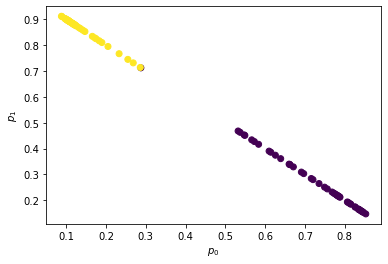

In [351]:
%pylab inline
scatter(pbs_arr[:,0],pbs_arr[:,1],c=[y_lab for x_lab,y_lab in xy_labels])
xlabel(r"$p_{0}$")
ylabel(r"$p_{1}$");

## Non-linearly-separable data

In [357]:
n_features=iris.data.shape[1]
xy_labels=[(iris.data[idx,:],iris.target[idx]) for idx in range(len(iris.data))]
feature_list=[[x_lab[ft_i] for x_lab,y_lab in xy_labels] for ft_i in range(n_features)]

#standardize features
mean_std_list=[[np.mean(feature_list[ft_i]),np.std(feature_list[ft_i])] for ft_i in range(n_features)]
xy_labels_stdd=[([(el[0][ft_i]-mean_std_list[ft_i][0])/mean_std_list[ft_i][1] for ft_i in range(n_features)],el[1]) for ei,el in enumerate(xy_labels)]
#norms_list=[np.sqrt(np.sum([val**2 for val in el[0]])) for el in xy_labels_stdd]
#xy_labels_stdd=[([val/norms_list[ei] for val in el[0]],el[1]) for ei,el in enumerate(xy_labels_stdd)]
xy_labels=xy_labels_stdd
#xy_labels

X=np.array([x for x,y in xy_labels_stdd])
y_=np.array([y for x,y in xy_labels_stdd])
#y = torch.unsqueeze(torch.tensor(y,requires_grad=False), 1)
#y_hot = torch.scatter(torch.zeros((200, 2),requires_grad=False), 1, y_, 1)
X = torch.tensor(X, requires_grad=False).float()
y = torch.tensor(y_, requires_grad=False).long()

In [369]:
import pennylane.numpy as np

#def init_method(w):
#    print(w)
#    torch.nn.init.uniform_(w, a=0.0, b=0.02*np.pi)
#    print(w)
s=0.05
init_method=lambda x: torch.nn.init.uniform_(x,a=0.,b=s*np.pi)

n_qubits1=3
n_layers1 = 4
n_pars1 = 2*n_qubits1*n_layers1
dev1 = qml.device("default.mixed", wires=n_qubits1)
@qml.qnode(dev1)
def probs_single1(inputs, weights):
    shape=[2,4,3]
    nq=np.max([shape[0],shape[2]])
#    # load input
#    print("inputs:",inputs)
#    print("weights:",weights)
    #TODO: make general loadings
    for idx in range(0,n_features):
        gate=qml.RX if idx<shape[0] else qml.RZ
        gate(np.arctan(inputs[...,idx]),idx%2,id=f"$\\alpha1_{{{{{idx}}}}}$")
        
    # parameterized circuit 
    for lay_idx in range(shape[1]):
        ctr=0
        for eo in range(2):
            for qi in range(eo,nq-eo,2):
                if qi<nq-1:
                    qml.CZ(wires=[qi,qi+1])
        for gate in [qml.RX,qml.RZ]:
            for qi in range(nq):
                gate(weights[lay_idx][ctr],wires=qi,id=f"$\\theta1_{{{{{ctr}}}}}$")
                ctr+=1
        
    probs=qml.probs(wires=range(0,shape[2]))
    return probs
weight_shapes1 = {"weights": (n_layers1, n_pars1)}
qlayer1 = qml.qnn.TorchLayer(probs_single1, weight_shapes1,init_method=init_method)


n_qubits2=3
n_layers2 = 3
n_pars2 = 2*n_qubits2*n_layers2
dev2 = qml.device("default.mixed", wires=n_qubits2)
@qml.qnode(dev2)
def probs_single2(inputs, weights):
    shape=[3,3,2]
    nq=np.max([shape[0],shape[2]])
#    # load input
#    print("inputs:",inputs)
#    print("weights:",weights)
    #TODO: make general loadings
    for idx in range(0,6):
        gate=qml.RY if idx<3 else qml.RZ
        gate(torch.arctan(np.pi*(inputs[...,idx]-0.5)),idx%3,id=f"$\\alpha2_{{{{{idx}}}}}$")
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])
    for idx in range(6,8):
        #gate=[qml.RX,qml.RZ][idx-6]
        qml.RY(torch.arctan(np.pi*(inputs[...,idx]-0.5)),idx-6,id=f"$\\alpha2_{{{{{idx}}}}}$")
        
    # parameterized circuit 
    for lay_idx in range(shape[1]):
        ctr=0
        for eo in range(2):
            for qi in range(eo,nq-eo,2):
                if qi<nq-1:
                    qml.CZ(wires=[qi,qi+1])
        for gate in [qml.RY,qml.RZ]:
            for qi in range(nq):
                gate(weights[lay_idx][ctr],wires=qi,id=f"$\\theta2_{{{{{ctr}}}}}$")
                ctr+=1
        
    probs=qml.probs(wires=range(0,shape[2]))
    return probs
weight_shapes2 = {"weights": (n_layers2, n_pars2)}
qlayer2 = qml.qnn.TorchLayer(probs_single2, weight_shapes2,init_method=init_method)

In [370]:
import pennylane.numpy as np
layers = [qlayer1,qlayer2]
model = torch.nn.Sequential(*layers)
#model.apply(init_method)

#opt = torch.optim.SGD(model.parameters(), lr=0.1)
opt = torch.optim.Adam(model.parameters(),lr=0.05)
#opt = torch.optim.Adam(model.parameters(),lr=0.05)
#loss = torch.nn.MSELoss()
loss = torch.nn.CrossEntropyLoss()
for pr in model.parameters():
    print(pr)

Parameter containing:
tensor([[0.0197, 0.0392, 0.1460, 0.0898, 0.0393, 0.1028, 0.1287, 0.0741, 0.1148,
         0.1238, 0.0233, 0.0245, 0.1342, 0.0911, 0.0719, 0.0993, 0.1443, 0.0151,
         0.0942, 0.0344, 0.0256, 0.0847, 0.0975, 0.0121],
        [0.0859, 0.0719, 0.0241, 0.1470, 0.1345, 0.1079, 0.0717, 0.1314, 0.0416,
         0.0119, 0.0708, 0.0081, 0.0603, 0.0526, 0.0370, 0.0551, 0.1154, 0.1524,
         0.0472, 0.0145, 0.1343, 0.1528, 0.1048, 0.1049],
        [0.0007, 0.1423, 0.0340, 0.1258, 0.0265, 0.1186, 0.1111, 0.1374, 0.1042,
         0.0622, 0.0477, 0.1480, 0.0764, 0.0853, 0.0770, 0.1436, 0.0829, 0.0684,
         0.1476, 0.0438, 0.0183, 0.0153, 0.1440, 0.0913],
        [0.0567, 0.1186, 0.0820, 0.1536, 0.0623, 0.0844, 0.1526, 0.0022, 0.0255,
         0.1039, 0.0165, 0.0328, 0.0237, 0.0992, 0.0495, 0.1391, 0.0813, 0.1448,
         0.0199, 0.0234, 0.1162, 0.0310, 0.1547, 0.0179]], requires_grad=True)
Parameter containing:
tensor([[0.1191, 0.1399, 0.0509, 0.1184, 0.0190, 0.0720

In [371]:
#y = y_hot.float()
#y_hot = y_hot.float()

batch_size = 4
batches = 300 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y)), batch_size=batch_size, shuffle=True, drop_last=True
)
epochs = 20

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

#        print(xs)
        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()
#        print(xs, model(xs),ys,loss_evaluated)

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.6252
Average loss over epoch 2: 0.5990
Average loss over epoch 3: 0.5717
Average loss over epoch 4: 0.5847
Average loss over epoch 5: 0.5675
Average loss over epoch 6: 0.5622
Average loss over epoch 7: 0.5571
Average loss over epoch 8: 0.5718
Average loss over epoch 9: 0.5530
Average loss over epoch 10: 0.5711
Average loss over epoch 11: 0.5640
Average loss over epoch 12: 0.5637
Average loss over epoch 13: 0.5836
Average loss over epoch 14: 0.5522
Average loss over epoch 15: 0.5511
Average loss over epoch 16: 0.5523
Average loss over epoch 17: 0.5552
Average loss over epoch 18: 0.5451
Average loss over epoch 19: 0.5463
Average loss over epoch 20: 0.5651
Accuracy: 70.66666666666667%


In [372]:
pbs_arr=[]
for x_lab, y_lab in zip(X,y):
    pbs=model(x_lab).detach().numpy()
    pbs_arr.append(pbs[:3])
    idx_max=np.argmax(pbs)
#    y_lab_pred="0" if idx_max==1 else "1"
    print(int(y_lab), " ", idx_max, " ", pbs)
pbs_arr=np.array(pbs_arr)

0   0   [0.88862073 0.04666363 0.0312213  0.03349442]
0   0   [0.61602986 0.18724692 0.17082089 0.02590257]
0   0   [0.81822586 0.085311   0.06609107 0.03037224]
0   0   [0.74663204 0.12409202 0.09751393 0.03176221]
0   0   [0.895419   0.04164632 0.02878664 0.03414799]
0   0   [0.8982133  0.03933984 0.02569382 0.03675316]
0   0   [0.8848951  0.04881867 0.03337402 0.03291228]
0   0   [0.8813746  0.05125135 0.03430223 0.03307194]
0   0   [0.49465626 0.27534163 0.19902647 0.03097574]
0   0   [0.7408608  0.12459187 0.10518397 0.02936358]
0   0   [0.88973826 0.0462505  0.02825265 0.03575872]
0   0   [0.884962   0.04886497 0.03243196 0.03374111]
0   0   [0.62008923 0.18741995 0.16521314 0.02727788]
0   0   [0.6041811  0.19555517 0.17348675 0.02677714]
0   0   [0.85168076 0.07157549 0.03749689 0.03924711]
0   0   [0.8815013  0.05279895 0.02533056 0.04036929]
0   0   [0.8968433  0.04072732 0.02617492 0.03625459]
0   0   [0.8906113  0.04531591 0.03065123 0.03342168]
0   0   [0.87041724 0.059855